In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Download MBTA bus data if it hasn't been downloaded yet
from download_mbta_data import download_mbta_bus_data

download_mbta_bus_data()

data/MBTA_Bus_Arrival_Departure_Times_2024 folder already exists, skipping download and unzip
data/MBTA_Bus_Arrival_Departure_Times_2025 folder already exists, skipping download and unzip


In [5]:
from retrieve_weather_data import retrieve_weather_data

retrieve_weather_data()

Downloaded 2024 weather data
Downloaded 2025 weather data


In [6]:
import pandas as pd
from glob import glob

mbta_2024_files = glob("data/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024*.csv")
mbta_2025_files = glob("data/MBTA_Bus_Arrival_Departure_Times_2025/MBTA-Bus-Arrival-Departure-Times_2025*.csv")
mbta_2024_data = pd.concat([pd.read_csv(f) for f in mbta_2024_files], ignore_index=True)
mbta_2025_data = pd.concat([pd.read_csv(f) for f in mbta_2025_files], ignore_index=True)
mbta_data = pd.concat([mbta_2024_data, mbta_2025_data], axis=0, ignore_index=True)

mbta_data["route_id"].value_counts()

/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/4179997816.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  mbta_2025_data = pd.concat([pd.read_csv(f) for f in mbta_2025_files], ignore_index=True)


route_id
111    2310232
28     1405315
23     1376703
SL1    1363949
39     1218013
        ...   
75          46
71          42
74          42
76          17
68          15
Name: count, Length: 173, dtype: int64

In [7]:
mbta_data['service_date'].astype(str).str.startswith('2025').sum()

np.int64(23320778)

In [8]:
mbta_data['service_date'].astype(str).str.startswith('2024').sum()

np.int64(27049203)

In [9]:
mbta_data.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway
0,2024-09-01,01,Inbound,64240110.0,110,hhgat,1,Startpoint,Schedule,1900-01-01T11:05:00Z,1900-01-01T11:05:21Z,NaN,NaN
1,2024-09-01,01,Inbound,64240110.0,67,maput,2,Midpoint,Schedule,1900-01-01T11:09:00Z,1900-01-01T11:06:57Z,NaN,NaN
2,2024-09-01,01,Inbound,64240110.0,72,cntsq,3,Midpoint,Schedule,1900-01-01T11:12:00Z,1900-01-01T11:09:43Z,NaN,NaN
3,2024-09-01,01,Inbound,64240110.0,75,mit,4,Midpoint,Schedule,1900-01-01T11:15:00Z,1900-01-01T11:14:13Z,NaN,NaN
4,2024-09-01,01,Inbound,64240110.0,79,hynes,5,Midpoint,Schedule,1900-01-01T11:19:00Z,1900-01-01T11:17:53Z,NaN,NaN


In [10]:
mbta_data.dropna(subset=["service_date","route_id", "scheduled" ,"actual"],inplace=True)
mbta_data["route_id"].value_counts()

route_id
111    2198410
28     1303103
23     1296006
39     1134011
66     1122513
        ...   
75          46
74          41
71          39
76          16
68          15
Name: count, Length: 173, dtype: int64

In [11]:
filtered_mbta_data = mbta_data[["service_date","route_id", "scheduled" ,"actual"]]
filtered_mbta_data["service_date"] = pd.to_datetime(filtered_mbta_data["service_date"])
filtered_mbta_data["scheduled"] = pd.to_datetime(filtered_mbta_data["scheduled"])
filtered_mbta_data["actual"] = pd.to_datetime(filtered_mbta_data["actual"])


/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/1260497511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mbta_data["service_date"] = pd.to_datetime(filtered_mbta_data["service_date"])
/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/1260497511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mbta_data["scheduled"] = pd.to_datetime(filtered_mbta_data["scheduled"])
/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/1260497511.py:4: Sett

In [12]:
import gc

var_list = ['mbta_data', 'mbta_2024_data', 'mbta_2025_data', 'mbta_2024_files', 'mbta_2025_files']

for var in var_list:
    if var in globals():
        del globals()[var]

gc.collect()


60

In [13]:
#%pip install holidays
import holidays

filtered_mbta_data["day_of_week"] = filtered_mbta_data["service_date"].dt.dayofweek  # Monday=0
filtered_mbta_data["is_weekend"] = filtered_mbta_data["day_of_week"].isin([5, 6]).astype(int)

us_holidays = holidays.US(years=[2024, 2025])
filtered_mbta_data["is_holiday"] = filtered_mbta_data["service_date"].dt.date.isin(us_holidays).astype(int)

print(len(filtered_mbta_data))
filtered_mbta_data.head()

46901864


,service_date,route_id,scheduled,actual,day_of_week,is_weekend,is_holiday
0,2024-09-01,01,1900-01-01 11:05:00+00:00,1900-01-01 11:05:21+00:00,6,1,0
1,2024-09-01,01,1900-01-01 11:09:00+00:00,1900-01-01 11:06:57+00:00,6,1,0
2,2024-09-01,01,1900-01-01 11:12:00+00:00,1900-01-01 11:09:43+00:00,6,1,0
3,2024-09-01,01,1900-01-01 11:15:00+00:00,1900-01-01 11:14:13+00:00,6,1,0
4,2024-09-01,01,1900-01-01 11:19:00+00:00,1900-01-01 11:17:53+00:00,6,1,0


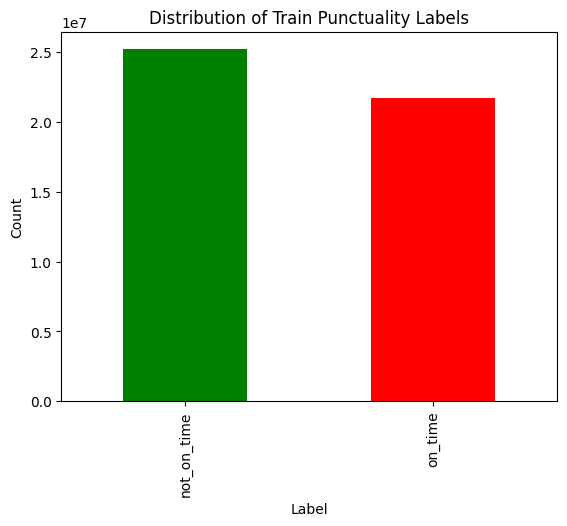

In [14]:
import matplotlib.pyplot as plt

# Calculate delay in minutes and assign labels
def assing_labels(delay):
    if -3 <= delay <= 3:
        return "on_time"
    else:
        return "not_on_time"

filtered_mbta_data["delay_minutes"] = (filtered_mbta_data["actual"] - filtered_mbta_data["scheduled"]).dt.total_seconds() / 60
filtered_mbta_data["label"] = filtered_mbta_data["delay_minutes"].apply(assing_labels)


filtered_mbta_data["label"].value_counts().plot(kind="bar", color=["green", "red", "blue"])
plt.title("Distribution of Train Punctuality Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [15]:
#Prepare weather data
weather_data_2024 = pd.read_csv("data/2024_72509014739.csv")
weather_data_2025 = pd.read_csv("data/2025_72509014739.csv")
weather_data = pd.concat([weather_data_2024, weather_data_2025], axis=0, ignore_index=True)
weather_data["DATE"] = pd.to_datetime(weather_data["DATE"])
filtered_weather_data = weather_data[["DATE","WND","TMP","AA1","AA2","AA3"]]
def parse_precip(field):
    try:
        return float(field.split(",")[0]) / 10
    except:
        return 0.0
    
def parse_tmp_to_int(tmp):
    try:
        value = int(tmp.split(",")[0])
        return round(value / 10)
    except:
        return None  # handle missing or malformed values
    
def parse_wnd(wnd):
    try:
        parts = wnd.split(",")
        wind_dir_deg = int(parts[0])
        wind_speed_mps = round(int(parts[3]) / 10)
        return pd.Series({
            "wind_dir_deg": wind_dir_deg,
            "wind_speed_mps": wind_speed_mps
        })
    except:
        return pd.Series({
            "wind_dir_deg": None,
            "wind_speed_mps": None
        })
    
filtered_weather_data["precip_aa1"] = filtered_weather_data["AA1"].apply(parse_precip)
filtered_weather_data["precip_aa2"] = filtered_weather_data["AA2"].apply(parse_precip)
filtered_weather_data["precip_aa3"] = filtered_weather_data["AA3"].apply(parse_precip)
filtered_weather_data["TMP"] = filtered_weather_data["TMP"].apply(parse_tmp_to_int)
df_wind = filtered_weather_data["WND"].apply(parse_wnd)
filtered_weather_data = pd.concat([filtered_weather_data, df_wind], axis=1)

filtered_weather_data["precip_mm"] = filtered_weather_data[["precip_aa1", "precip_aa2", "precip_aa3"]].sum(axis=1)
filtered_weather_data = filtered_weather_data.drop(columns=["AA1","AA2","AA3"])
filtered_weather_data["is_rainy"] = (filtered_weather_data["precip_mm"] > 0).astype(int)

filtered_weather_data = filtered_weather_data[filtered_weather_data["TMP"] < 45]
filtered_weather_data = filtered_weather_data[filtered_weather_data["wind_speed_mps"] < 999]

filtered_weather_data.head()




/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/435391237.py:2: DtypeWarning: Columns (34,42,43,47,52,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data_2024 = pd.read_csv("data/2024_72509014739.csv")
/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/435391237.py:3: DtypeWarning: Columns (35,40,41,42,43,47,52,56,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data_2025 = pd.read_csv("data/2025_72509014739.csv")
/var/folders/3r/88snk92d11b587958zlh76b80000gn/T/ipykernel_52523/435391237.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_data["precip_aa1"] = filtered_weather_data["AA1"].apply(parse_precip)
/var/f

,DATE,WND,TMP,precip_aa1,precip_aa2,precip_aa3,wind_dir_deg,wind_speed_mps,precip_mm,is_rainy
0,2024-01-01 00:00:00,"340,1,N,0046,1",2,0.0,0.0,0.0,340,5,0.0,0
1,2024-01-01 00:54:00,"350,5,N,0046,5",1,0.1,0.0,0.0,350,5,0.1,1
2,2024-01-01 01:54:00,"340,5,N,0036,5",1,0.1,0.0,0.0,340,4,0.1,1
3,2024-01-01 02:54:00,"340,5,N,0036,5",1,0.1,0.0,0.0,340,4,0.1,1
4,2024-01-01 03:00:00,"340,1,N,0036,1",1,0.0,0.0,0.0,340,4,0.0,0


In [16]:
filtered_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22474 entries, 0 to 23104
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            22474 non-null  datetime64[ns]
 1   WND             22474 non-null  object        
 2   TMP             22474 non-null  int64         
 3   precip_aa1      22474 non-null  float64       
 4   precip_aa2      22474 non-null  float64       
 5   precip_aa3      22474 non-null  float64       
 6   wind_dir_deg    22474 non-null  int64         
 7   wind_speed_mps  22474 non-null  int64         
 8   precip_mm       22474 non-null  float64       
 9   is_rainy        22474 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 1.9+ MB


In [17]:
filtered_weather_data['DATE'].astype(str).str.startswith('2024').sum()

np.int64(13567)

In [18]:
filtered_weather_data['DATE'].astype(str).str.startswith('2025').sum()

np.int64(8907)

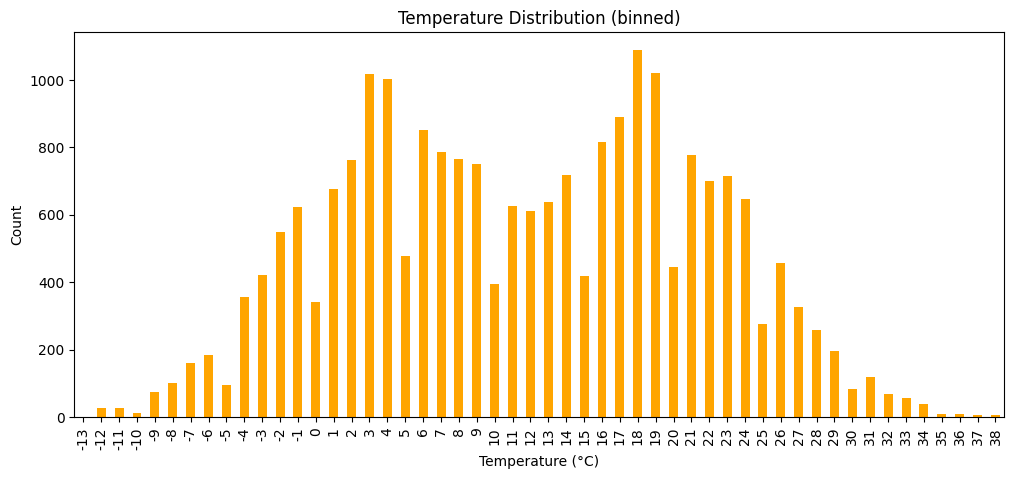

In [19]:
# Count per bin
temp_counts = filtered_weather_data["TMP"].value_counts().sort_index()

# Plot
temp_counts.plot(kind="bar", color="orange", figsize=(12,5))
plt.title("Temperature Distribution (binned)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.show()


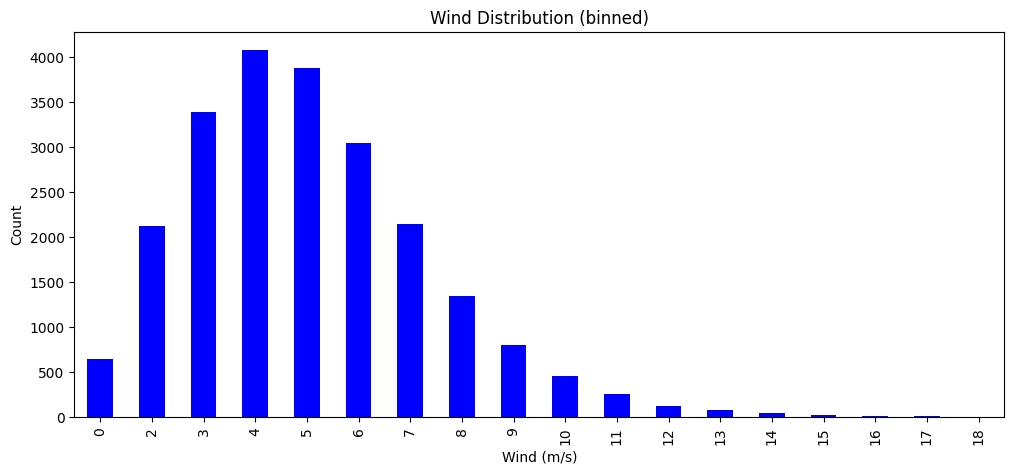

In [20]:
# Count per bin
wind_counts = filtered_weather_data["wind_speed_mps"].value_counts().sort_index()

# Plot
wind_counts.plot(kind="bar", color="blue", figsize=(12,5))
plt.title("Wind Distribution (binned)")
plt.xlabel("Wind (m/s)")
plt.ylabel("Count")
plt.show()

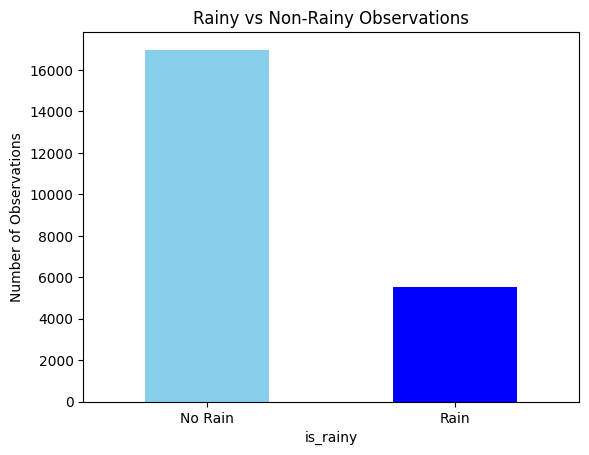

In [21]:
rain_counts = filtered_weather_data["is_rainy"].value_counts()

# Plot
rain_counts.plot(kind="bar", color=["skyblue", "blue"])
plt.xticks([0, 1], ["No Rain", "Rain"], rotation=0)
plt.ylabel("Number of Observations")
plt.title("Rainy vs Non-Rainy Observations")
plt.show()

In [22]:
# Merge based on closest timestamp
combined = pd.merge_asof(
    filtered_mbta_data.sort_values("service_date"),
    filtered_weather_data.sort_values("DATE"),
    left_on="service_date",
    right_on="DATE",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
)

print(len(combined))

combined.dropna(inplace=True)
print(len(combined))
combined.head()

46901864
42160356


,service_date,route_id,scheduled,actual,day_of_week,is_weekend,is_holiday,delay_minutes,label,DATE,WND,TMP,precip_aa1,precip_aa2,precip_aa3,wind_dir_deg,wind_speed_mps,precip_mm,is_rainy
0,2024-01-01,SL5,1900-01-01 17:30:00+00:00,1900-01-01 17:30:34+00:00,0,0,1,0.566667,on_time,2024-01-01,"340,1,N,0046,1",2.0,0.0,0.0,0.0,340.0,5.0,0.0,0.0
1,2024-01-01,60,1900-01-01 06:15:00+00:00,1900-01-01 06:17:58+00:00,0,0,1,2.966667,on_time,2024-01-01,"340,1,N,0046,1",2.0,0.0,0.0,0.0,340.0,5.0,0.0,0.0
2,2024-01-01,60,1900-01-01 06:17:00+00:00,1900-01-01 06:19:59+00:00,0,0,1,2.983333,on_time,2024-01-01,"340,1,N,0046,1",2.0,0.0,0.0,0.0,340.0,5.0,0.0,0.0
3,2024-01-01,60,1900-01-01 06:23:00+00:00,1900-01-01 06:24:54+00:00,0,0,1,1.900000,on_time,2024-01-01,"340,1,N,0046,1",2.0,0.0,0.0,0.0,340.0,5.0,0.0,0.0
4,2024-01-01,60,1900-01-01 07:00:00+00:00,1900-01-01 07:11:41+00:00,0,0,1,11.683333,not_on_time,2024-01-01,"340,1,N,0046,1",2.0,0.0,0.0,0.0,340.0,5.0,0.0,0.0


In [23]:
var_list = ['weather_data', 'weather_data_2024', 'weather_data_2025', 'filtered_weather_data', 'df_wind', 'filtered_mbta_data']

for var in var_list:
    if var in globals():
        del globals()[var]

gc.collect()

22914

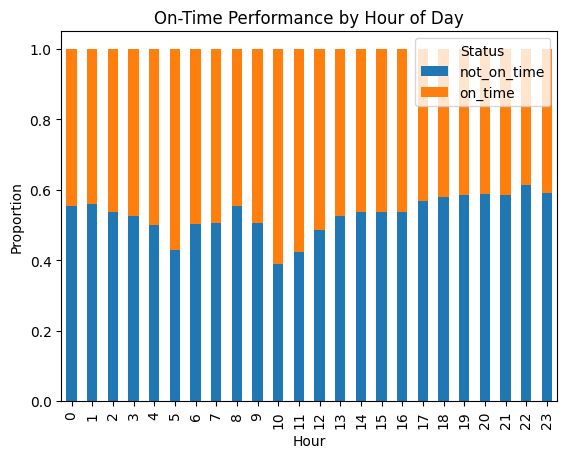

In [24]:
combined["hour"] = combined["actual"].dt.hour
combined.groupby("hour")["label"].value_counts(normalize=True).unstack().plot(kind="bar", stacked=True)
plt.title("On-Time Performance by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Proportion")
plt.legend(title="Status")
plt.show()


In [25]:
combined['is_morning_peak'] = combined['hour'].between(7, 10)
combined['is_evening_peak'] = combined['hour'].between(16, 19)
combined['month'] = combined['service_date'].dt.month
combined['season'] = combined['month'] // 3

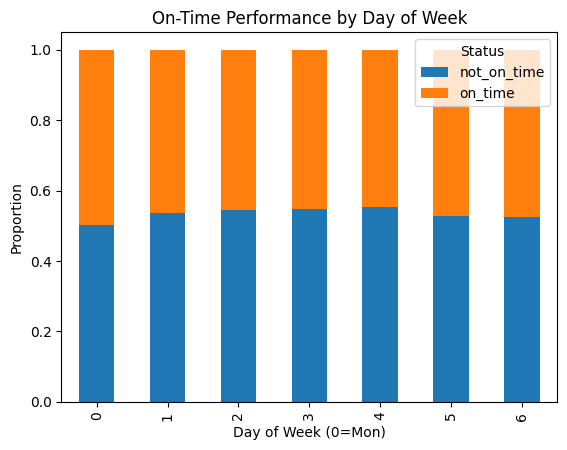

In [26]:
combined.groupby("day_of_week")["label"].value_counts(normalize=True).unstack().plot(kind="bar", stacked=True)
plt.title("On-Time Performance by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Proportion")
plt.legend(title="Status")
plt.show()

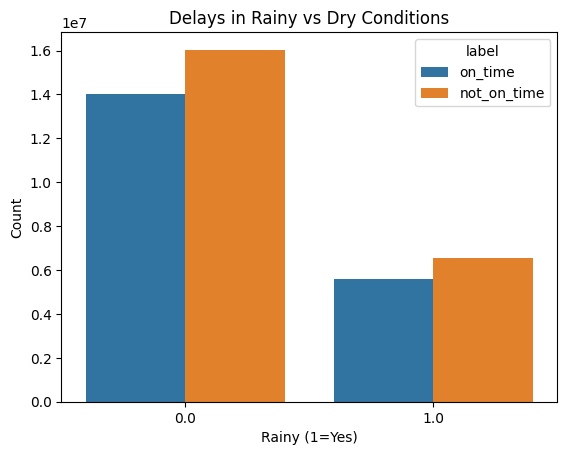

In [27]:
import seaborn as sns
sns.countplot(x="is_rainy", hue="label", data=combined)
plt.title("Delays in Rainy vs Dry Conditions")
plt.xlabel("Rainy (1=Yes)")
plt.ylabel("Count")
plt.show()


In [28]:
# Train random forest model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

label_encoder = LabelEncoder()
combined["label_encoded"] = label_encoder.fit_transform(combined["label"])
combined['route_id'] = combined['route_id'].astype(str)
combined['route_encoded'] = LabelEncoder().fit_transform(combined['route_id'])

features = [
    "route_encoded", "day_of_week", "is_weekend", "is_holiday",
    "TMP", "is_rainy", "wind_speed_mps", "wind_dir_deg", "hour", "is_morning_peak", "is_evening_peak", "delay_minutes", "season", "month"
]

for col in features:
    if 'int' in str(combined[col].dtype):
        combined[col] = combined[col].astype('int32')
    elif 'float' in str(combined[col].dtype):
        combined[col] = combined[col].astype('float32')

train_df = combined[combined['service_date'].dt.year == 2024]
test_df  = combined[combined['service_date'].dt.year == 2025]

df_2025_train, df_2025_test = train_test_split(
    test_df,
    test_size=0.50,
    stratify=test_df['label_encoded'],
    random_state=42
)

train_df = pd.concat([train_df, df_2025_train])
test_df  = df_2025_test

X_train = train_df[features]
y_train = train_df["label_encoded"]
X_test = test_df[features]
y_test = test_df["label_encoded"]

route_avg = X_train.groupby("route_encoded")["delay_minutes"].mean().rename("route_avg_delay")
hour_avg = X_train.groupby("hour")["delay_minutes"].mean().rename("hour_avg_delay")
route_hour_avg = (
    X_train
    .groupby(["route_encoded", "hour"])["delay_minutes"]
    .mean()
    .rename("route_hour_avg_delay")
    .reset_index()
)

X_train = X_train.join(route_avg, on="route_encoded")
X_train = X_train.join(hour_avg, on="hour")
X_test = X_test.join(route_avg, on="route_encoded")
X_test = X_test.join(hour_avg, on="hour")
X_train = X_train.merge(route_hour_avg, on=["route_encoded", "hour"], how="left")
X_test = X_test.merge(route_hour_avg, on=["route_encoded", "hour"], how="left")


X_test["route_hour_avg_delay"].fillna(X_test["route_avg_delay"], inplace=True)

global_avg_delay = X_train["delay_minutes"].mean()
X_test["route_avg_delay"].fillna(global_avg_delay, inplace=True)
X_test["route_hour_avg_delay"].fillna(global_avg_delay, inplace=True)

X_train = X_train.drop(columns=["delay_minutes"])
X_test = X_test.drop(columns=["delay_minutes"])

X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33579856 entries, 0 to 33579855
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   route_encoded         int32  
 1   day_of_week           int32  
 2   is_weekend            int32  
 3   is_holiday            int32  
 4   TMP                   float32
 5   is_rainy              float32
 6   wind_speed_mps        float32
 7   wind_dir_deg          float32
 8   hour                  int32  
 9   is_morning_peak       bool   
 10  is_evening_peak       bool   
 11  season                int32  
 12  month                 int32  
 13  route_avg_delay       float32
 14  hour_avg_delay        float32
 15  route_hour_avg_delay  float32
dtypes: bool(2), float32(7), int32(7)
memory usage: 1.8 GB


In [29]:
var_list = ['combined', 'train_df', 'test_df', 'df_2025_train', 'df_2025_test']

for var in var_list:
    if var in globals():
        del globals()[var]
        
gc.collect()

14613

In [30]:
rf = RandomForestClassifier(
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42,
    n_estimators=250,
    max_depth=15,
    min_samples_split=20,
    verbose=2
)


rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 7 of 250building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 6 of 250
building tree 5 of 250
building tree 1 of 250
building tree 8 of 250

building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250building tree 19 of 250

building tree 20 of 250
building tree 21 of 250building tree 22 of 250
building tree 23 of 250

building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.9min


building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250building tree 40 of 250

building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250building tree 68 of 250

building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 85.5min


building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250
building tree 178 of 250
building tree 179 of 250
building tree 180 of 250
building tree 181 of 250
building tree 182 of 250
building tree 183 of 250
building tree 184 of 250
building tree 185 of 250
building tree 186 of 250
building tree 187 of 250
building tree 188 of 250
building tree 189 of 250
building tree 190 of 250
building tree 191 of 250
building tree 192 of 250
building tree 193 of 250
building tree 194 of 250


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 141.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:   49.1s finished


              precision    recall  f1-score   support

 not_on_time       0.61      0.56      0.58   4371588
     on_time       0.58      0.63      0.61   4208912

    accuracy                           0.59   8580500
   macro avg       0.60      0.60      0.59   8580500
weighted avg       0.60      0.59      0.59   8580500



In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",
        C=1.0
    ))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

 not_on_time       0.59      0.56      0.58   4371588
     on_time       0.56      0.59      0.58   4208912

    accuracy                           0.58   8580500
   macro avg       0.58      0.58      0.58   8580500
weighted avg       0.58      0.58      0.58   8580500

